<a href="https://colab.research.google.com/github/kirill-kozlitin/GPN_hackathon/blob/main/check_autologreg.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

Провести тестирование выборки на предмет применимости в тестах
1. Построить автологрег
2. Оценить фичи, которые входят

In [103]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [104]:
!pip install xlsxwriter

In [105]:
!pip install optbinning

In [106]:
import pandas as pd
import sys

path = 'drive/MyDrive/VTB/'
sys.path.append(path)

import vtb_mlkit
from vtb_mlkit.scorekit.model import LogisticRegressionModel
from vtb_mlkit.scorekit.data import DataSamples


In [107]:
data = pd.read_csv(path + 'accepted_2007_to_2018Q4.csv.gz', compression='gzip', nrows=1*10**4)

In [108]:
description = pd.read_excel(path + 'lending_club_description.xlsx')
description.index = description.index.astype(str) # костыль. Должно работать на любых данных

In [109]:
month_dct = {
    'Jan':'01',
    'Feb':'02',
    'Mar':'03',
    'Apr':'04',
    'May':'05',
    'Jun':'06',
    'Jul':'07',
    'Aug':'08',
    'Sep':'09',
    'Oct':'10',
    'Nov':'11',
    'Dec':'12'
}

data.dropna(subset=['issue_d'], axis='index', inplace=True)
data['date'] = data['issue_d'].apply(lambda x: f'01.{month_dct[x[:3]]}.{x[-4:]}')

In [110]:
# data['date'] = pd.to_datetime(data['date'], format='%d.%m.%Y')

In [111]:
# data[['term', 'pymnt_plan', 'initial_list_status', 'application_type', 'hardship_flag', 'debt_settlement_flag']]
data['loan_status'].value_counts(dropna=False)

Fully Paid            7189
Charged Off           1713
Current               1024
Late (31-120 days)      58
In Grace Period         12
Late (16-30 days)        4
Name: loan_status, dtype: int64

In [112]:
data['target'] = data['loan_status'].apply(lambda x: 0 if x == 'Fully Paid' else 1)

In [113]:
bad_features = ['id', # понятно
                'member_id', # понятно
                'desc', # описание кредита
                'title', # описание кредита
                'last_pymnt_amnt', # сумма посл. платежа. (лик)
                'acc_now_delinq', # кол. просрочек сейчас (лик)
                'total_pymnt', # уплач. сумма (лик)
                'total_pymnt_inv', # уплач. проц (лик)
                'total_rec_prncp', # уплач. сумма (лик)
                'total_rec_int', # уплач. проц (лик)
                'total_rec_late_fee', # уплач. проц (лик)
                'next_pymnt_d', # дата след. платежа (лик)
                'last_pymnt_amnt', # сумма послед. платежа (лик)
                'last_fico_range_low', # рейтинг текущ. (лик)
                'last_fico_range_high', # рейтинг текущ. (лик)
                'loan_status', # текущ. статус (лик)
                ]

In [114]:
data.drop(bad_features, axis='columns', inplace=True)

In [115]:
ds = DataSamples(samples={'train': data.copy()}, feature_descriptions=description, target='target', time_column='date', result_folder='data_output', samples_split={}, bootstrap_split={}, ci_analytic=False)

logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-25 09:56:00] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-25 09:56:00] Selected 126 features: ['loan_amnt', 'funded_amnt', 'funded_amnt_inv', 'term', 'int_rate', 'installment', 'grade', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'issue_d', 'pymnt_plan', 'purpose', 'dti', 'delinq_2yrs', 'fico_range_low', 'fico_range_high', 'inq_last_6mths', 'mths_since_last_delinq', 'mths_since_last_record', 'open_acc', 'pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_act_il', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 'total_bal_il'

[INFO] [2023-07-25 09:56:02] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-25 09:56:02] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-25 09:56:02] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-25 09:56:02] Processing 126 features on 1 CPU...


100%|██████████| 126/126 [04:21<00:00,  2.07s/it]


[INFO] [2023-07-25 10:00:25] Excluded 48 features ['emp_length', 'issue_d', 'pymnt_plan', 'mths_since_last_record', 'pub_rec', 'initial_list_status', 'out_prncp', 'out_prncp_inv', 'recoveries', 'collection_recovery_fee', 'collections_12_mths_ex_med', 'policy_code', 'application_type', 'tot_coll_amt', 'total_cu_tl', 'chargeoff_within_12_mths', 'delinq_amnt', 'mo_sin_old_il_acct', 'mo_sin_rcnt_rev_tl_op', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'num_accts_ever_120_pd', 'num_rev_accts', 'num_tl_30dpd', 'num_tl_90g_dpd_24m', 'tax_liens', 'revol_bal_joint', 'sec_app_fico_range_low', 'sec_app_fico_range_high', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_flag', 'hardship_reason', 'hardship_status', 'hardship_amount', 'hardship_dpd',

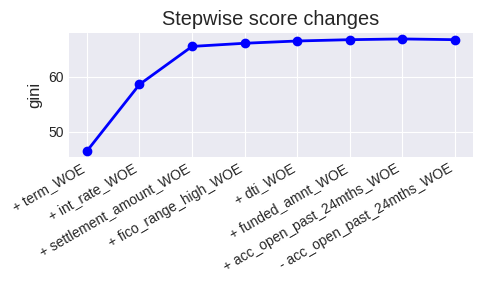

[INFO] [2023-07-25 10:01:14] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-25 10:01:15] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-25 10:01:15] Nothing to drop
[INFO] [2023-07-25 10:01:15] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-25 10:01:15] intercept = -0.86
[INFO] [2023-07-25 10:01:15] coefs = {'term_WOE': -0.768, 'settlement_amount_WOE': -0.978, 'int_rate_WOE': -0.578, 'funded_amnt_WOE': -0.18, 'fico_range_high_WOE': -0.672, 'dti_WOE': -0.569}
[INFO] [2023-07-25 10:01:16] Generating report...


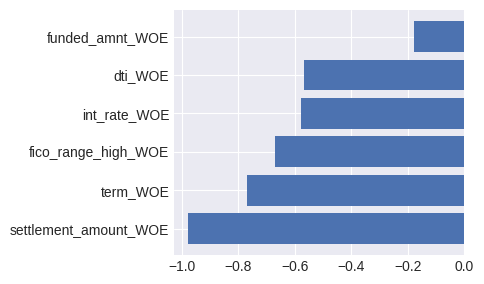

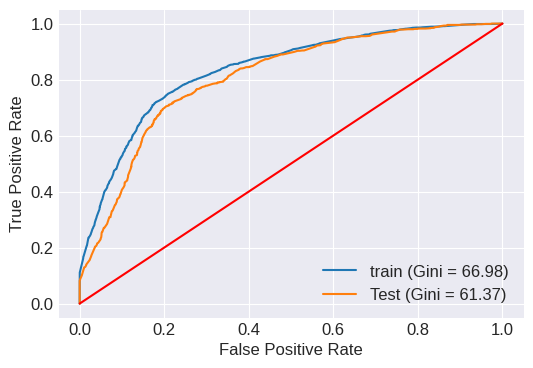

[INFO] [2023-07-25 10:01:22] 
      train   Test  CI_lower  CI_upper
Gini  66.98  61.37     63.48      67.2


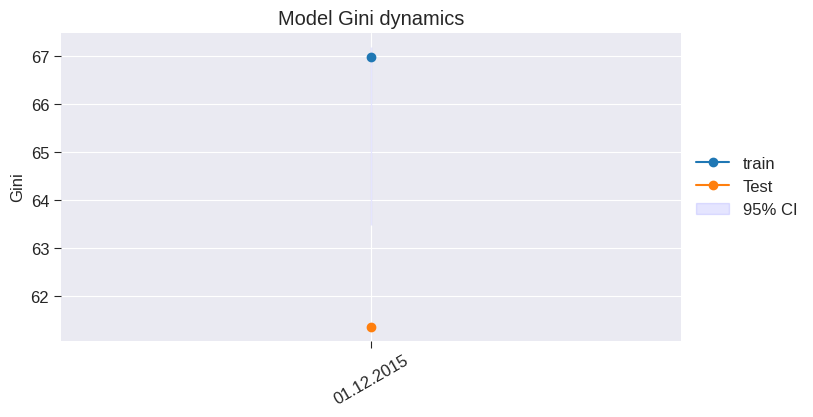

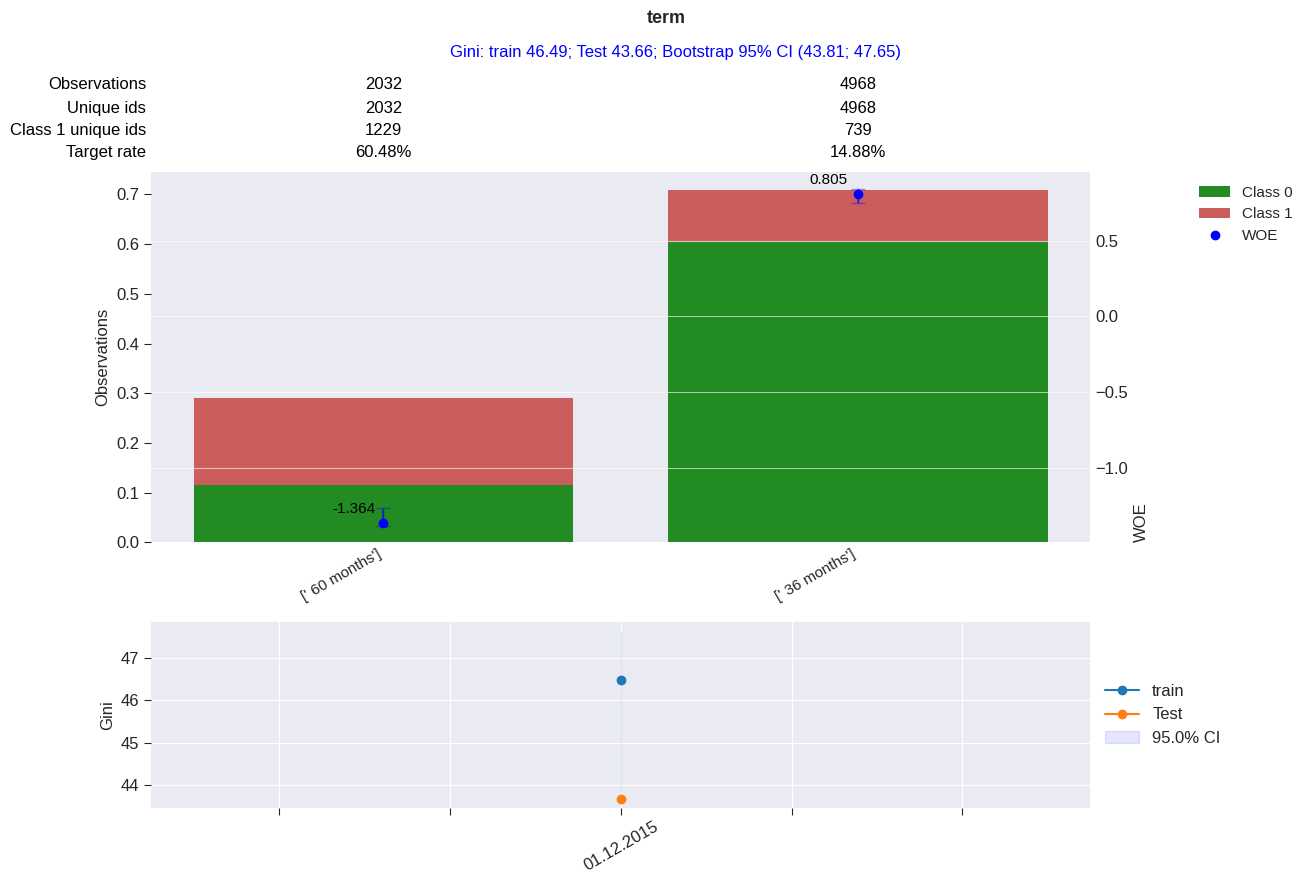

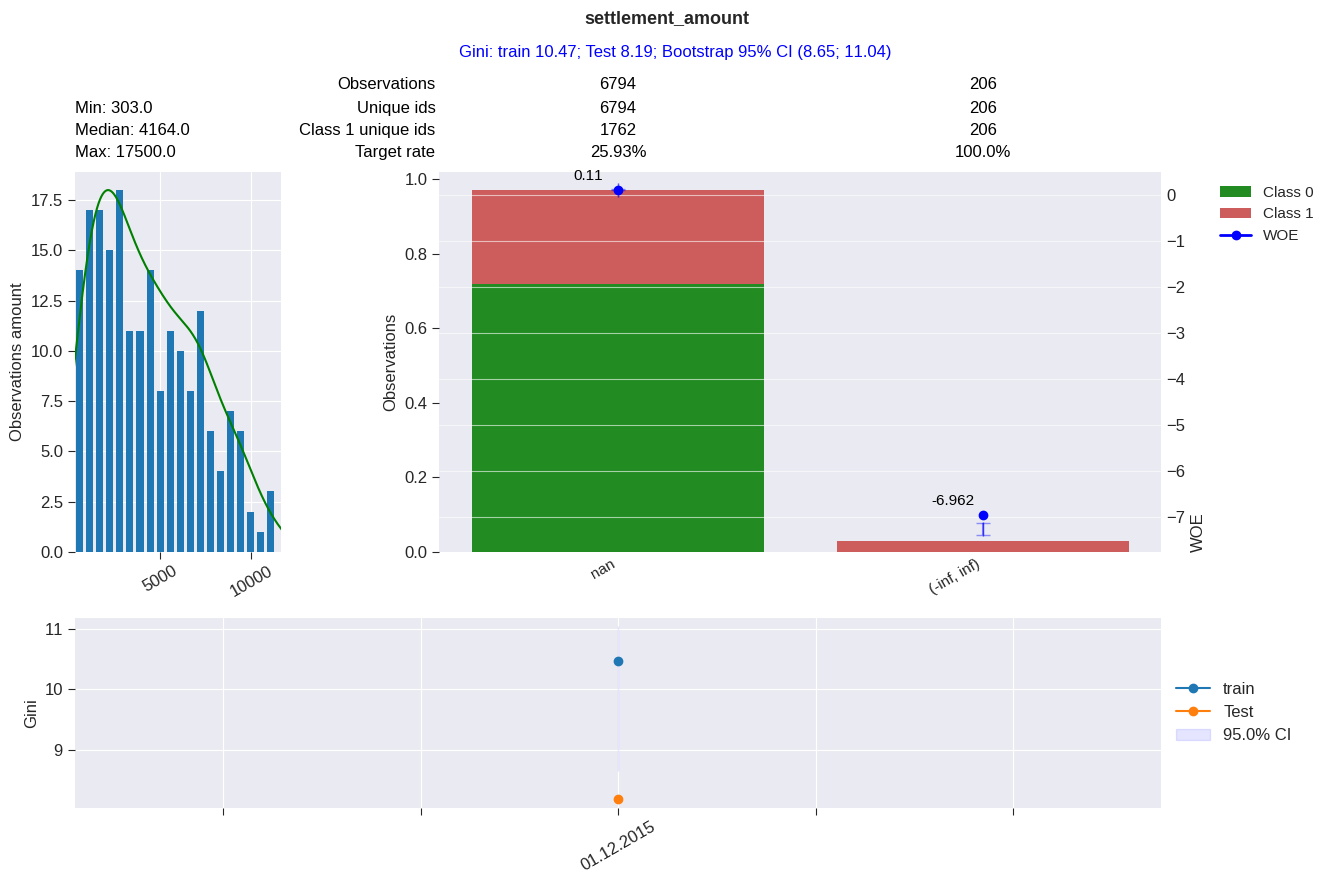

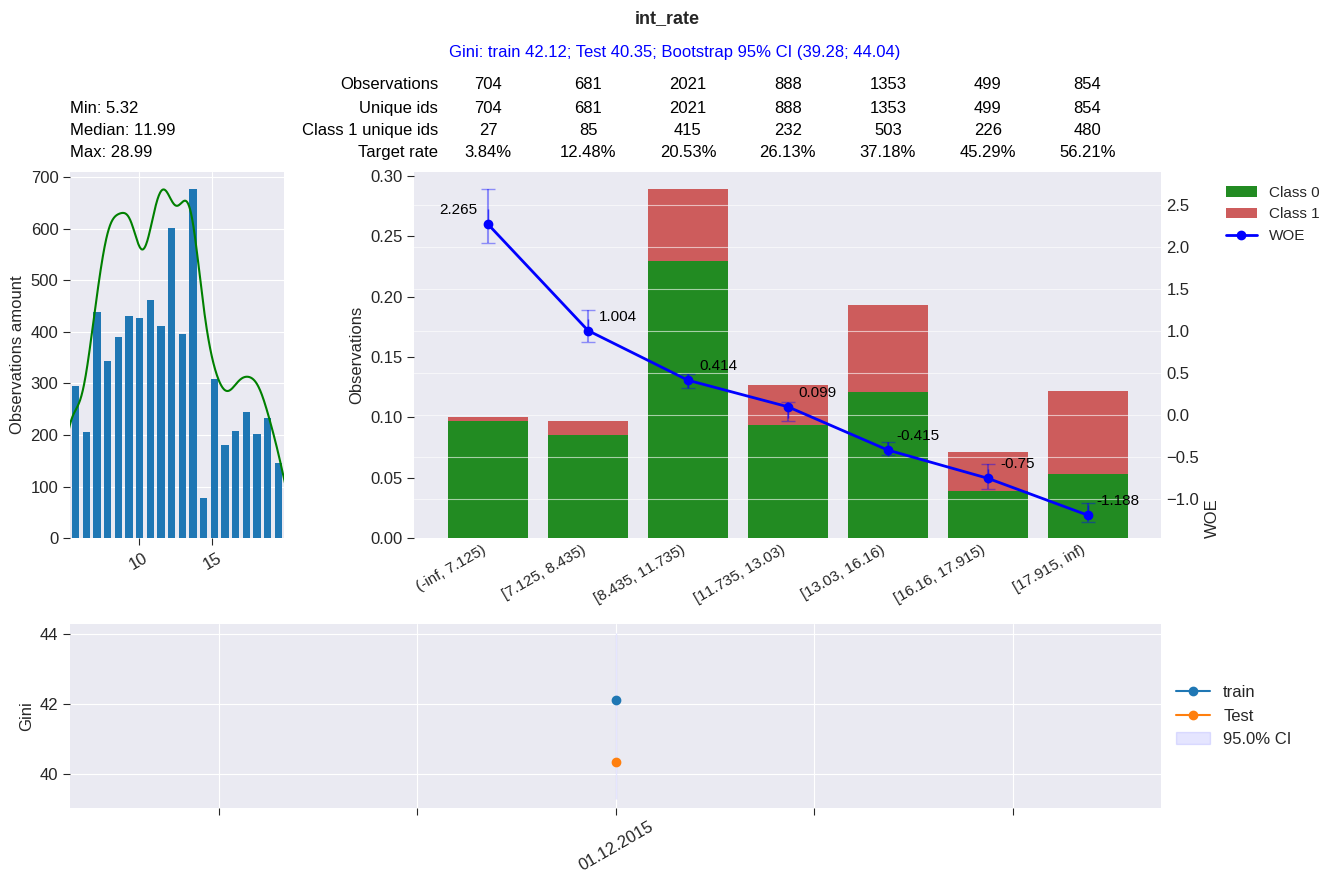

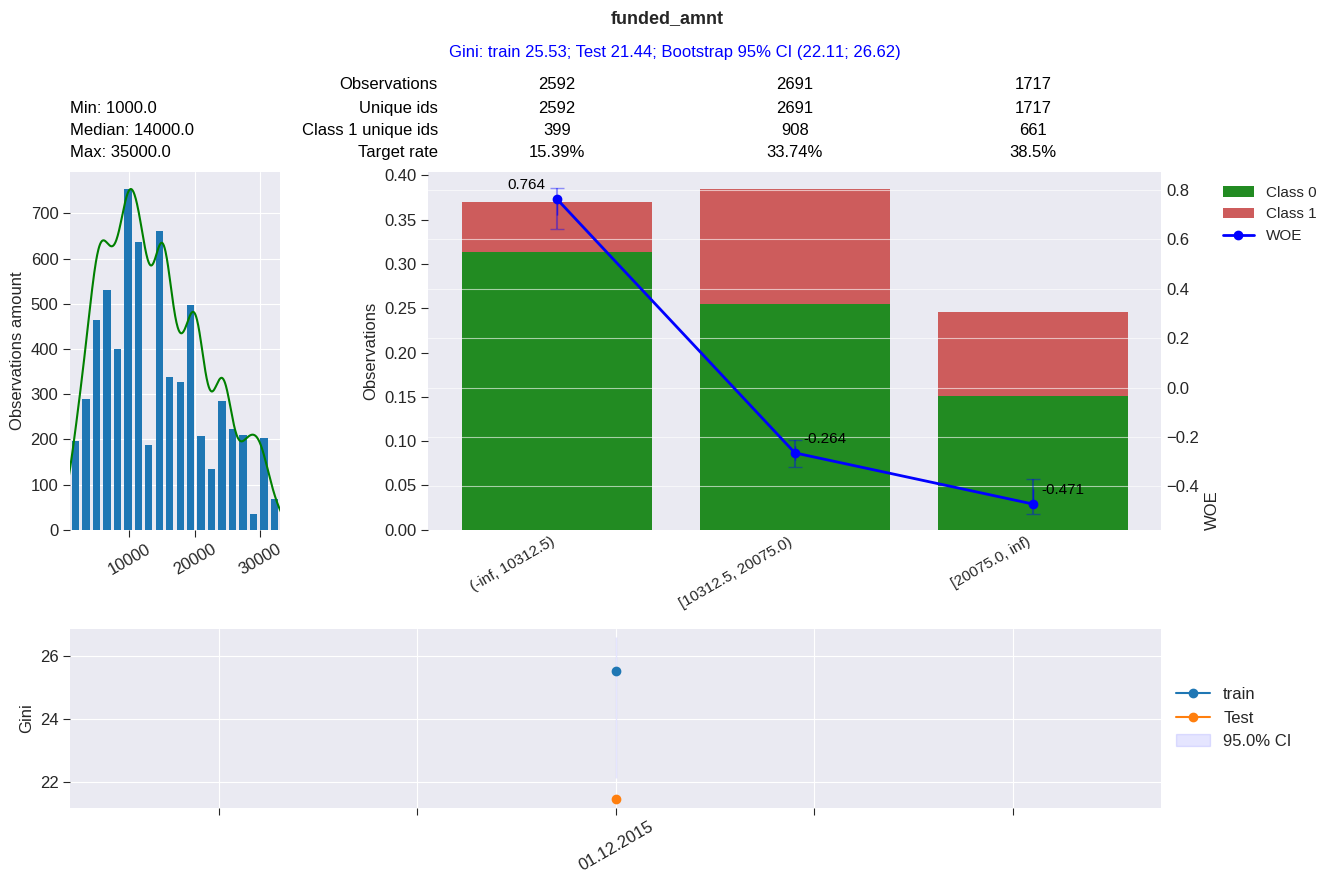

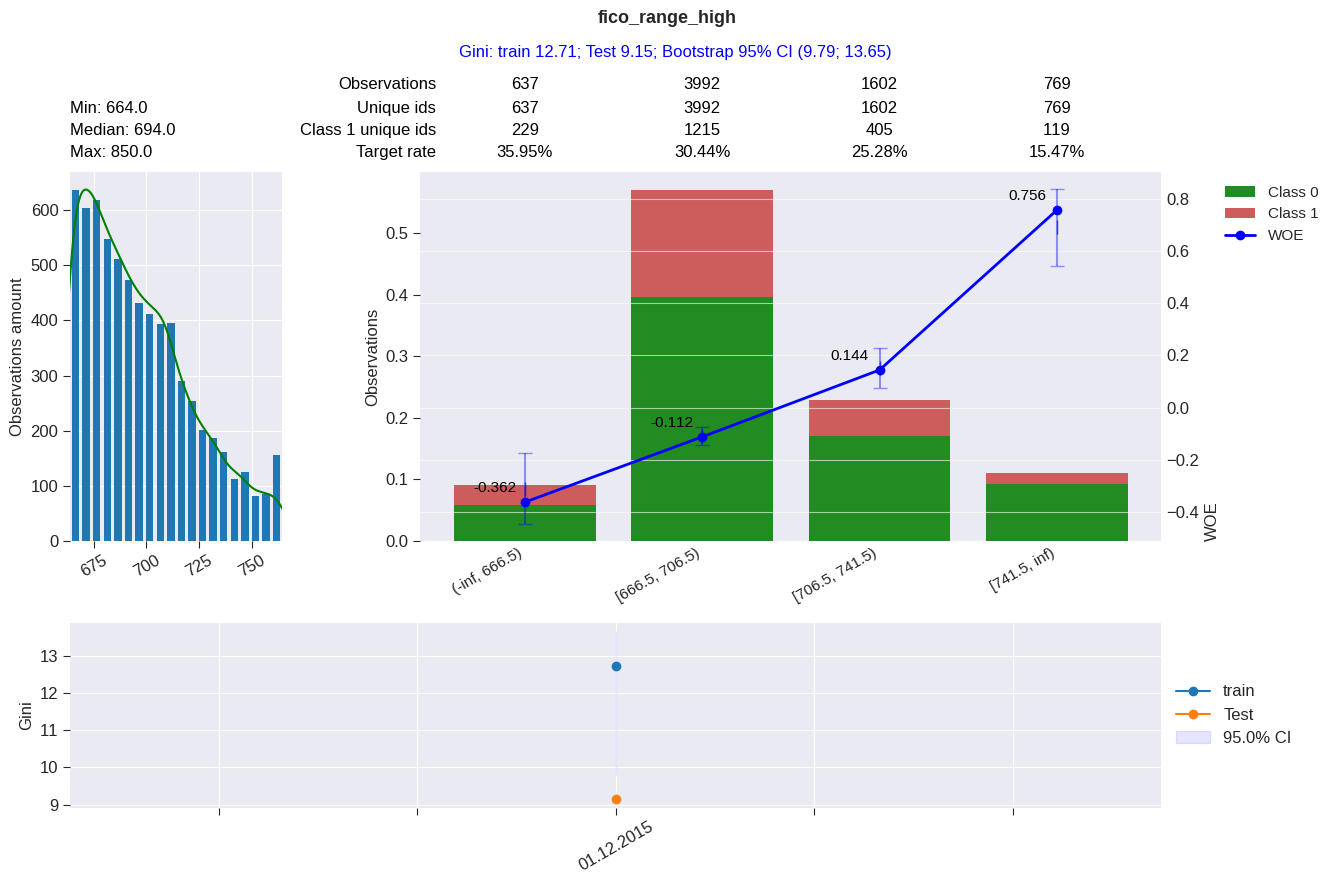

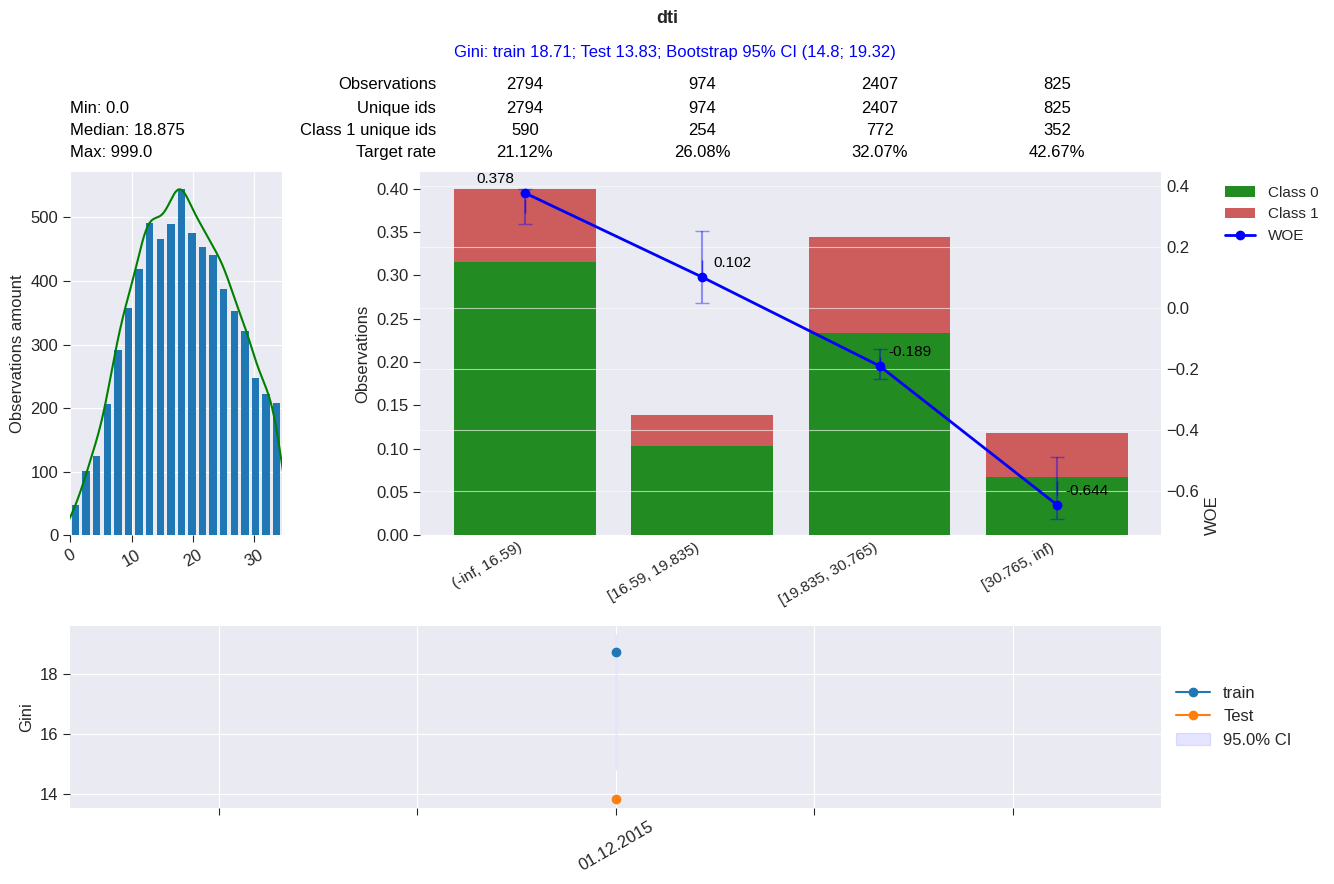

[INFO] [2023-07-25 10:02:06] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-25 10:02:07] The model was successfully saved to file data_output/auto_model.json


In [116]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=description, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [117]:
# logreg.features

In [118]:
gini_features = ds.calc_gini()
gini_features['train'] = gini_features['train'].apply(lambda x: abs(x))
gini_features = gini_features.sort_values(by='train', ascending=False)

In [119]:
good_features = []
for ind, row in gini_features.iterrows():
  if row['train'] > 0:
    good_features += [ind]

In [120]:
data = data[good_features + ['date', 'target']]

In [121]:
!pip install tsfresh

In [122]:
ds = DataSamples(samples={'train': data.copy()}, target='target', result_folder='titanic_output')

[INFO] [2023-07-25 10:02:45] ---------------------------------------------------------------- Creating DataSamples ----------------------------------------------------------------
[INFO] [2023-07-25 10:02:45] Selected 52 features: ['recoveries', 'collection_recovery_fee', 'int_rate', 'out_prncp', 'out_prncp_inv', 'funded_amnt', 'loan_amnt', 'funded_amnt_inv', 'dti', 'installment', 'fico_range_low', 'fico_range_high', 'acc_open_past_24mths', 'total_bal_ex_mort', 'num_rev_tl_bal_gt_0', 'total_il_high_credit_limit', 'num_actv_rev_tl', 'num_tl_op_past_12m', 'num_il_tl', 'inq_last_6mths', 'num_sats', 'open_acc', 'revol_bal', 'num_actv_bc_tl', 'mort_acc', 'mo_sin_rcnt_tl', 'mo_sin_old_rev_tl_op', 'num_op_rev_tl', 'mo_sin_rcnt_rev_tl_op', 'total_bc_limit', 'total_acc', 'num_bc_sats', 'avg_cur_bal', 'total_rev_hi_lim', 'tot_hi_cred_lim', 'delinq_2yrs', 'tot_coll_amt', 'num_tl_90g_dpd_24m', 'pub_rec_bankruptcies', 'num_rev_accts', 'num_bc_tl', 'tot_cur_bal', 'collections_12_mths_ex_med', 'charg

In [123]:
ds.features

['recoveries',
 'collection_recovery_fee',
 'int_rate',
 'out_prncp',
 'out_prncp_inv',
 'funded_amnt',
 'loan_amnt',
 'funded_amnt_inv',
 'dti',
 'installment',
 'fico_range_low',
 'fico_range_high',
 'acc_open_past_24mths',
 'total_bal_ex_mort',
 'num_rev_tl_bal_gt_0',
 'total_il_high_credit_limit',
 'num_actv_rev_tl',
 'num_tl_op_past_12m',
 'num_il_tl',
 'inq_last_6mths',
 'num_sats',
 'open_acc',
 'revol_bal',
 'num_actv_bc_tl',
 'mort_acc',
 'mo_sin_rcnt_tl',
 'mo_sin_old_rev_tl_op',
 'num_op_rev_tl',
 'mo_sin_rcnt_rev_tl_op',
 'total_bc_limit',
 'total_acc',
 'num_bc_sats',
 'avg_cur_bal',
 'total_rev_hi_lim',
 'tot_hi_cred_lim',
 'delinq_2yrs',
 'tot_coll_amt',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'num_rev_accts',
 'num_bc_tl',
 'tot_cur_bal',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'num_accts_ever_120_pd',
 'num_tl_30dpd',
 'pct_tl_nvr_dlq',
 'annual_inc',
 'pub_rec',
 'delinq_amnt',
 'tax_liens',
 'date']

In [124]:
ds.feature_generator(features=None, prebinning=True, chunk_size=10000, gini_threshold=10, operands=True,
                     lags=True, aggs=None, corr_method='spearman', corr_thres=0.80)

[INFO] [2023-07-25 10:02:48] Creating combinations...


100%|██████████| 198/198 [00:23<00:00,  8.61it/s] 

[INFO] [2023-07-25 10:03:11] 198 features were generated, 41 of them passed the tests and were added to sample train


In [125]:
ds.features

['recoveries',
 'collection_recovery_fee',
 'int_rate',
 'out_prncp',
 'out_prncp_inv',
 'funded_amnt',
 'loan_amnt',
 'funded_amnt_inv',
 'dti',
 'installment',
 'fico_range_low',
 'fico_range_high',
 'acc_open_past_24mths',
 'total_bal_ex_mort',
 'num_rev_tl_bal_gt_0',
 'total_il_high_credit_limit',
 'num_actv_rev_tl',
 'num_tl_op_past_12m',
 'num_il_tl',
 'inq_last_6mths',
 'num_sats',
 'open_acc',
 'revol_bal',
 'num_actv_bc_tl',
 'mort_acc',
 'mo_sin_rcnt_tl',
 'mo_sin_old_rev_tl_op',
 'num_op_rev_tl',
 'mo_sin_rcnt_rev_tl_op',
 'total_bc_limit',
 'total_acc',
 'num_bc_sats',
 'avg_cur_bal',
 'total_rev_hi_lim',
 'tot_hi_cred_lim',
 'delinq_2yrs',
 'tot_coll_amt',
 'num_tl_90g_dpd_24m',
 'pub_rec_bankruptcies',
 'num_rev_accts',
 'num_bc_tl',
 'tot_cur_bal',
 'collections_12_mths_ex_med',
 'chargeoff_within_12_mths',
 'num_accts_ever_120_pd',
 'num_tl_30dpd',
 'pct_tl_nvr_dlq',
 'annual_inc',
 'pub_rec',
 'delinq_amnt',
 'tax_liens',
 'date',
 'gen_operands_loan_amnt_/_num_actv_re

In [126]:
ds.samples_split(df=None, test_size=.3, validate_size=0, split_type='oos', stratify=True, id_column=None)

[INFO] [2023-07-25 10:03:12] Actual parts of samples after samples split:
      train  Test
part    0.7   0.3


In [127]:
logreg = LogisticRegressionModel(clf=None,            # классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_). При None выбирается SGDClassifier(alpha=0.001, loss='log', max_iter=100)
                                 ds=ds,               # Привязанный к модели ДатаСэмпл. Если задан, то он по умолчанию будет использоваться во всех методах
                                 transformer=None,    # объект класса WOE для предварительной трансформации факторов
                                 round_digits=3,      # округление коэффициентов до этого кол-ва знаков после запятой
                                 name='loan',      # название модели
                                )


[INFO] [2023-07-25 10:03:12] Chosen model classifier is SGDClassifier(alpha=0.001, loss='log', random_state=0)


[INFO] [2023-07-25 10:03:12] ------------------------------------------------------------------------ SFA -------------------------------------------------------------------------
[INFO] [2023-07-25 10:03:12] Performing autobinning with parameters space of size 1...
[INFO] [2023-07-25 10:03:12] Using parameters set 1/1: {'method': 'opt', 'max_n_bins': 10, 'min_bin_size': 0.05, 'criterion': 'entropy', 'scoring': 'neg_log_loss', 'max_depth': 5, 'solver': 'cp', 'divergence': 'iv', 'WOEM_on': True, 'WOEM_woe_threshold': 0.05, 'WOEM_with_missing': False, 'SM_on': False, 'SM_target_threshold': 5, 'SM_size_threshold': 100, 'G_on': False, 'G_gini_threshold': 5, 'G_gini_decrease_threshold': 0.25, 'G_gini_increase_restrict': False, 'G_with_test': False, 'BL_on': True, 'BL_allow_Vlogic_to_increase_gini': 10, 'WOEO_on': True, 'WOEO_all_samples': False, 'verbose': False}
[INFO] [2023-07-25 10:03:12] Processing 93 features on 1 CPU...


100%|██████████| 93/93 [01:04<00:00,  1.44it/s]


[INFO] [2023-07-25 10:04:18] Excluded 16 features ['recoveries', 'collection_recovery_fee', 'out_prncp', 'out_prncp_inv', 'tot_coll_amt', 'num_tl_90g_dpd_24m', 'num_rev_accts', 'num_bc_tl', 'collections_12_mths_ex_med', 'chargeoff_within_12_mths', 'num_tl_30dpd', 'annual_inc', 'pub_rec', 'delinq_amnt', 'tax_liens', 'date'] because no suitable binning was found for them
[INFO] [2023-07-25 10:04:18] Scorecard saved to the file titanic_output/auto_fit_scorecard.xlsx
[INFO] [2023-07-25 10:04:18] All done! 77/93 features successfully binned.
[INFO] [2023-07-25 10:04:18] Transforming features...
[WARNING] [2023-07-25 10:04:18] Can't transform 16 features: ['out_prncp_WOE', 'tot_coll_amt_WOE', 'chargeoff_within_12_mths_WOE', 'tax_liens_WOE', 'out_prncp_inv_WOE', 'recoveries_WOE', 'collection_recovery_fee_WOE', 'num_rev_accts_WOE', 'num_tl_90g_dpd_24m_WOE', 'annual_inc_WOE', 'delinq_amnt_WOE', 'date_WOE', 'num_tl_30dpd_WOE', 'num_bc_tl_WOE', 'pub_rec_WOE', 'collections_12_mths_ex_med_WOE']
[IN

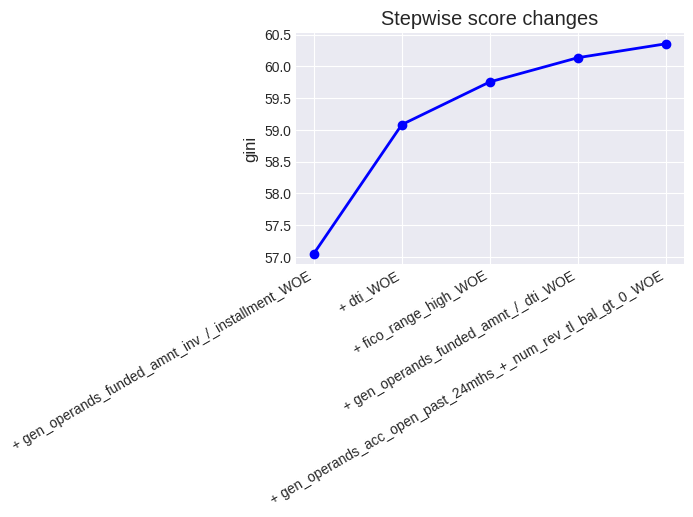

[INFO] [2023-07-25 10:04:47] ---------------------------------------------- Step 4 ----------------------------------------------
[INFO] [2023-07-25 10:04:47] Dropping features with positive coefs and high p-values...
[INFO] [2023-07-25 10:04:47] Nothing to drop
[INFO] [2023-07-25 10:04:47] ------------------------------------------- Final model --------------------------------------------
[INFO] [2023-07-25 10:04:47] intercept = -0.886
[INFO] [2023-07-25 10:04:47] coefs = {'gen_operands_funded_amnt_inv_/_installment_WOE': -0.952, 'gen_operands_funded_amnt_/_dti_WOE': -0.477, 'gen_operands_acc_open_past_24mths_+_num_rev_tl_bal_gt_0_WOE': -0.329, 'fico_range_high_WOE': -0.645, 'dti_WOE': -0.63}
[INFO] [2023-07-25 10:04:48] Generating report...


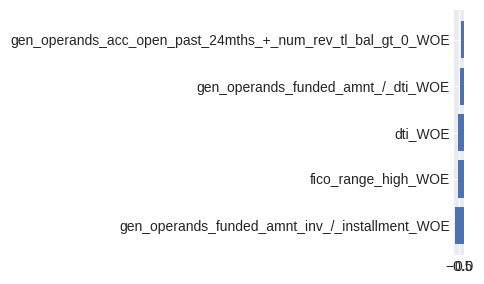

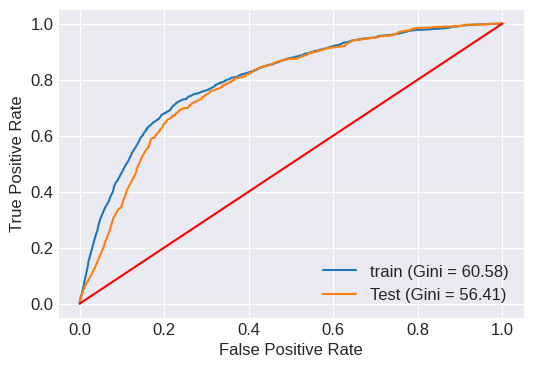

[INFO] [2023-07-25 10:04:50] 
      train   Test  CI_lower  CI_upper
Gini  60.58  56.41     58.07     63.09


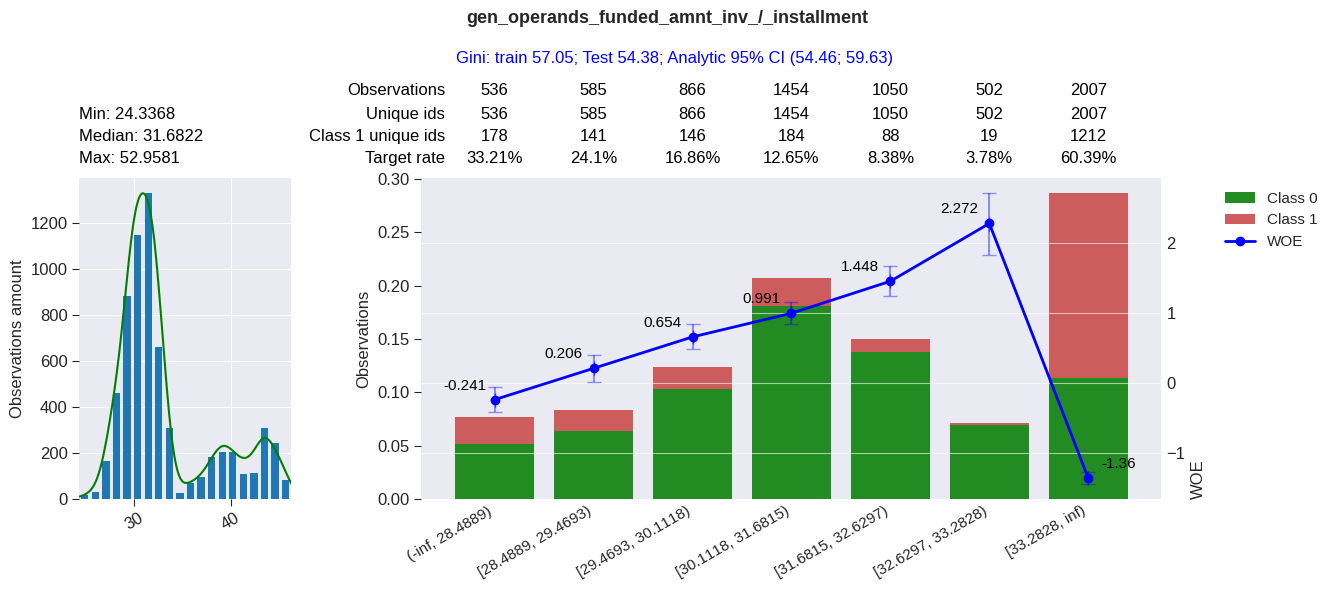

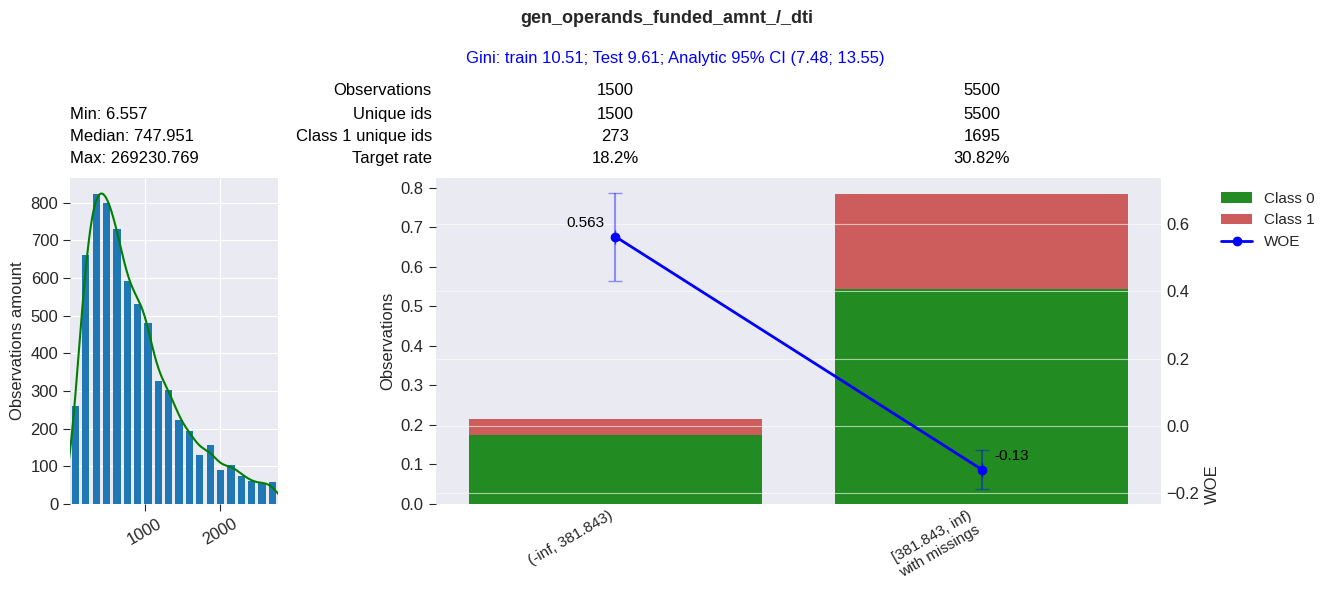

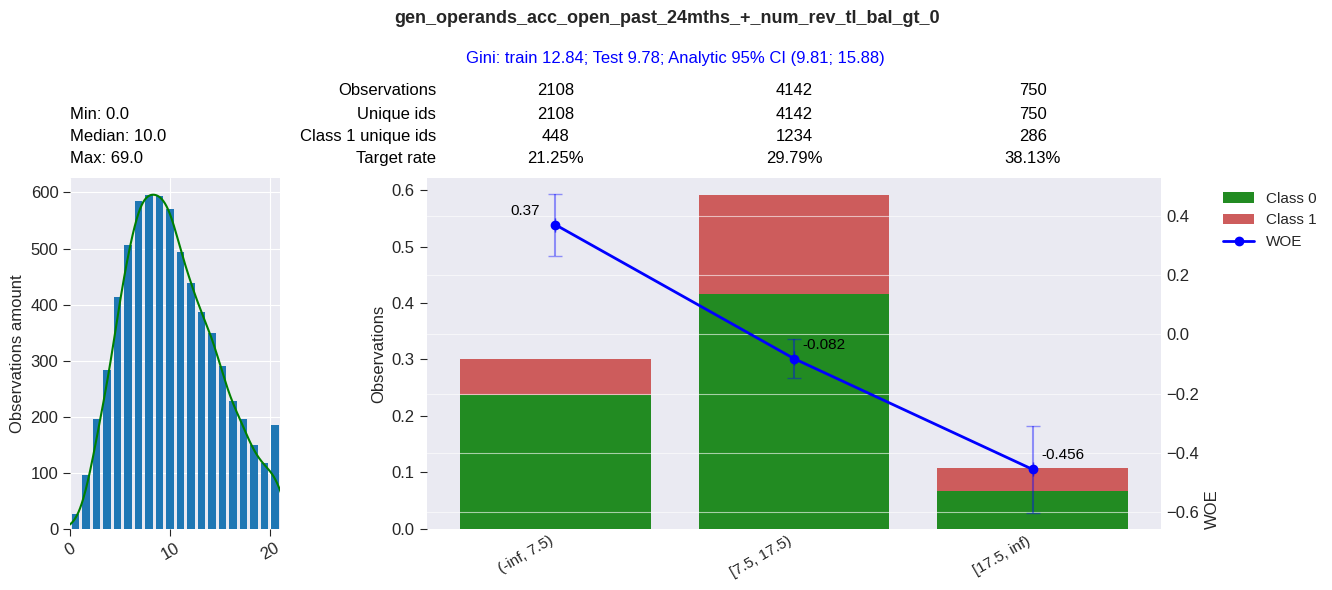

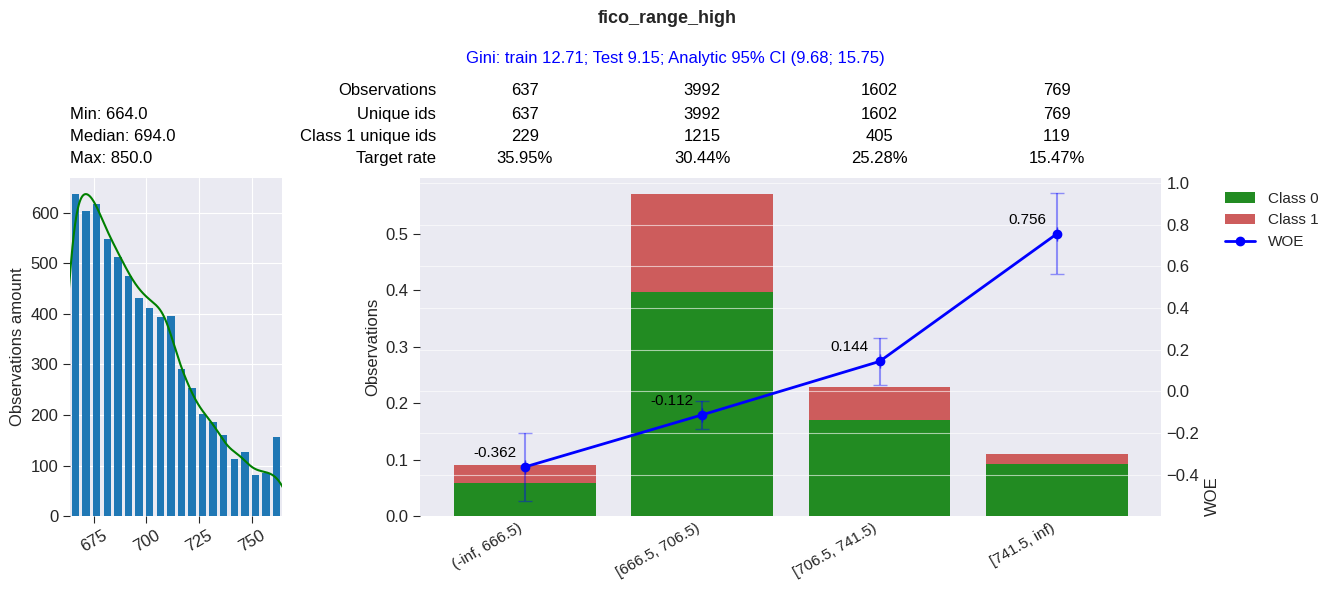

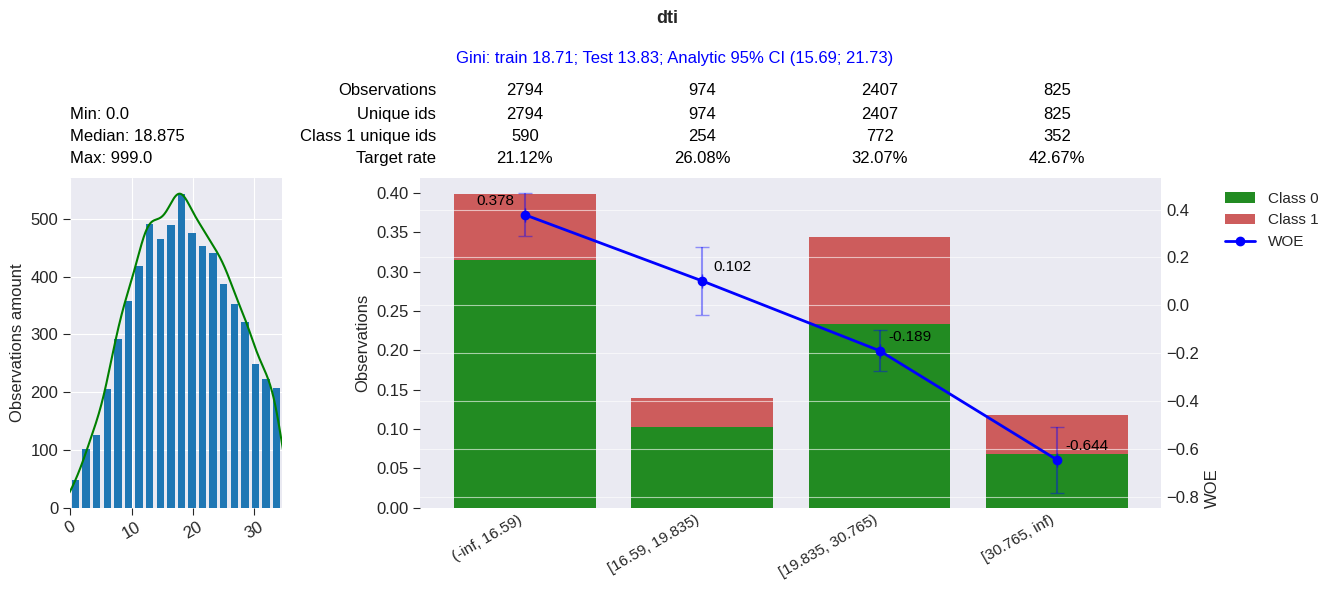

[INFO] [2023-07-25 10:05:03] The model report is saved to file auto_model.xlsx
[INFO] [2023-07-25 10:05:03] The model was successfully saved to file titanic_output/auto_model.json


In [128]:
logreg.auto_logreg(data=None, target=None, time_column=None, id_column=None, feature_descriptions=description, n_jobs=None,
                   result_folder='', method='opt', validate=False, out='auto_model.xlsx', save_model='auto_model.json')

In [129]:
logreg.features

['gen_operands_funded_amnt_inv_/_installment_WOE',
 'gen_operands_funded_amnt_/_dti_WOE',
 'gen_operands_acc_open_past_24mths_+_num_rev_tl_bal_gt_0_WOE',
 'fico_range_high_WOE',
 'dti_WOE']

In [130]:
ds.feature_descriptions

In [131]:
# классификатор модели (должен иметь метод fit() и атрибуты coef_, intercept_)
logreg.clf

SGDClassifier(alpha=0.001, loss='log', random_state=0)

In [132]:
# словарь коэффициентов
logreg.coefs

{'gen_operands_funded_amnt_inv_/_installment_WOE': -0.952,
 'gen_operands_funded_amnt_/_dti_WOE': -0.477,
 'gen_operands_acc_open_past_24mths_+_num_rev_tl_bal_gt_0_WOE': -0.329,
 'fico_range_high_WOE': -0.645,
 'dti_WOE': -0.63}

In [133]:
# константа логрега
logreg.intercept

-0.886

In [134]:
# список коэффициентов для калибровки [a, b]
# score_calibr = a + b*score
logreg.calibration

In [135]:
# словарь шкалы {грейд: верхняя граница PD грейда}
'''
пример мастер-шкалы:
{
'MA1': 0.00050,
'MA2': 0.00069,
'MA3': 0.00097,
'MB1': 0.0013,
'MB2': 0.0019,
'MB3': 0.0027,
'MC1': 0.0038,
'MC2': 0.0053,
'MC3': 0.0075,
'MD1': 0.010,
'MD2': 0.014,
'MD3': 0.020,
'ME1': 0.029,
'ME2': 0.041,
'ME3': 0.057,
'MF1': 0.081,
'MF2': 0.11,
'MF3': 0.16,
'MG1': 0.22,
'MG2': 0.31,
'MG3': 1
}
'''
logreg.scale

In [136]:
logreg.report(ds=None, out='report.xlsx', sheet_name=None, pvalue_threshold=0.05, verbose=False, add_figs=None, gini_df=None,
              plotbins_config=None, metrics=None, metrics_cv=None, cv=None)

[INFO] [2023-07-25 10:05:15] The model report is saved to file report.xlsx


Gini                  \
                                                    train   Test CI_lower   
feature                                                                     
gen_operands_funded_amnt_inv_/_installment_WOE      57.05  54.38    54.46   
gen_operands_funded_amnt_/_dti_WOE                  10.51   9.61     7.48   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...  12.84   9.78     9.81   
fico_range_high_WOE                                 12.71   9.15     9.68   
dti_WOE                                             18.71  13.83    15.69   
intercept                                             NaN    NaN      NaN   
model                                               60.58  56.41    58.07   

                                                            coefficient  \
                                                   CI_upper               
feature                                                                   
gen_operands_funded_amnt_inv_/_installment_WOE        59.63      -0.952   
gen_operands_funded_amnt_/_dti_WOE                    13.55      -0.477   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...    15.88      -0.329   
fico_range_high_WOE                                   15.75      -0.645   
dti_WOE                                               21.73      -0.630   
intercept                                               NaN      -0.886   
model                                                 63.09         NaN   

                                                       se Wald p-value  \
                                                                 train   
feature                                                                  
gen_operands_funded_amnt_inv_/_installment_WOE      0.029   1.761e-233   
gen_operands_funded_amnt_/_dti_WOE                  0.124    1.209e-04   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...  0.121    6.684e-03   
fico_range_high_WOE                                 0.119    5.496e-08   
dti_WOE                                             0.094    1.770e-11   
intercept                                           0.031   3.943e-178   
model                                                 NaN          NaN   

                                                                   ks         \
                                                          Test  train   Test   
feature                                                                        
gen_operands_funded_amnt_inv_/_installment_WOE      1.764e-102  0.477  0.467   
gen_operands_funded_amnt_/_dti_WOE                   1.159e-02  0.105  0.096   
gen_operands_acc_open_past_24mths_+_num_rev_tl_...   7.205e-02  0.102  0.065   
fico_range_high_WOE                                  4.203e-04  0.101  0.078   
dti_WOE                                              6.868e-06  0.152  0.123   
intercept                                            6.833e-77    NaN    NaN   
model                                                      NaN  0.488  0.455   

                                                      vif            iv         
                                                    train   Test  train   Test  
feature                                                                         
gen_operands_funded_amnt_inv_/_installment_WOE      1.147  1.139  1.245  1.143  
gen_operands_funded_amnt_/_dti_WOE                  1.189  1.188  0.073  0.060  
gen_operands_acc_open_past_24mths_+_num_rev_tl_...  1.073  1.066  0.066  0.043  
fico_range_high_WOE                                 1.067  1.064  0.077  0.040  
dti_WOE                                             1.225  1.207  0.121  0.068  
intercept                                             NaN    NaN    NaN    NaN  
model                                                 NaN    NaN  1.407  1.130

In [137]:
for i in data.columns:
  print(i)

recoveries
collection_recovery_fee
int_rate
out_prncp
out_prncp_inv
funded_amnt
loan_amnt
funded_amnt_inv
dti
installment
fico_range_low
fico_range_high
acc_open_past_24mths
total_bal_ex_mort
num_rev_tl_bal_gt_0
total_il_high_credit_limit
num_actv_rev_tl
num_tl_op_past_12m
num_il_tl
inq_last_6mths
num_sats
open_acc
revol_bal
num_actv_bc_tl
mort_acc
mo_sin_rcnt_tl
mo_sin_old_rev_tl_op
num_op_rev_tl
mo_sin_rcnt_rev_tl_op
total_bc_limit
total_acc
num_bc_sats
avg_cur_bal
total_rev_hi_lim
tot_hi_cred_lim
delinq_2yrs
tot_coll_amt
num_tl_90g_dpd_24m
pub_rec_bankruptcies
num_rev_accts
num_bc_tl
tot_cur_bal
collections_12_mths_ex_med
chargeoff_within_12_mths
num_accts_ever_120_pd
num_tl_30dpd
pct_tl_nvr_dlq
annual_inc
pub_rec
delinq_amnt
tax_liens
date
target
